In [ ]:
import os
import wer
import glob
from tqdm import tqdm
from vetrbi import MyViterbiDecoder
from utils import parse_lexicon, generate_symbol_tables


lex = parse_lexicon('lexicon.txt')
word_table, phone_table, state_table = generate_symbol_tables(lex)


def read_transcription(wav_file):
    """
    Get the transcription corresponding to wav_file.
    """
    
    transcription_file = os.path.splitext(wav_file)[0] + '.txt'
    
    with open(transcription_file, 'r') as f:
        transcription = f.readline().strip()
    
    return transcription


In [ ]:
from hmm import generate_word_sequence_recognition_wfst
from hmm import generate_word_sequence_recognition_wfst_with_silance
from hmm import generate_lexical_hmm

def create_wfst():
    f = generate_word_sequence_recognition_wfst(3)
    f.set_input_symbols(state_table)
    f.set_output_symbols(phone_table)
    return f

def create_wfst_with_silance():
    f = generate_word_sequence_recognition_wfst_with_silance(3, use_unigram_probs=False)
    f.set_input_symbols(state_table)
    f.set_output_symbols(phone_table)
    return f

def create_lexical():
    f = generate_lexical_hmm(1, use_unigram_probs=False)
    f.set_input_symbols(state_table)
    f.set_output_symbols(phone_table)
    return f


In [ ]:
f = create_wfst()
f_silence = create_wfst_with_silance()

In [ ]:
import openfst_python as fst
from subprocess import check_call
from IPython.display import Image
f_silence = fst.determinize(f_silence)
f_silence.draw('tmp.dot', portrait=True)
check_call(['dot','-Tpng','-Gdpi=400','tmp.dot','-o','tmp.png'])
Image(filename='tmp.png')

In [ ]:
all_losses = []
decoding_time = []
backtrace_time = []
number_of_computations = []
i = 0
train_split = int(0.85 * len(glob.glob('/group/teaching/asr/labs/recordings/*.wav')))  # replace path if using your own audio files
print(train_split)

all_transcriptions = ''
for wav_file in tqdm(glob.glob('/group/teaching/asr/labs/recordings/*.wav')):    # replace path if using your own
                                                                           # audio files
    
    decoder  = MyViterbiDecoder(f_silence, wav_file, verbose=False, use_pruning=False, determinized=True)
    decoder.decode()
    (state_path, words) = decoder.backtrace()  
    
    transcription = read_transcription(wav_file)
    all_transcriptions += transcription + ' '
    error_counts = wer.compute_alignment_errors(transcription, words)
    word_count = len(transcription.split())

    all_losses.append((error_counts, word_count))
    decoding_time.append(decoder.decode_time)
    backtrace_time.append(decoder.backtrace_time)
    number_of_computations.append(decoder.number_of_computiations)
    i += 1
    if i == 10:
        break

In [ ]:
# calculate the WER fo each file
import numpy as np
all_wer = []
for error_counts, word_count in all_losses:
    all_wer.append(sum(error_counts) / word_count)



print(f'The average WER is {np.mean(all_wer):.2%}')

In [ ]:
#Print dcoding time statistics
print(f'The average decoding time is {np.mean(decoding_time):.2f} seconds')
print(f'The average backtrace time is {np.mean(backtrace_time):.2f} seconds')
print(f'The average number of computations is {np.mean(number_of_computations):.2f}')



In [ ]:
# count unigram counts in all_transcriptions
unigram_counts = {}
for word in all_transcriptions.split():
    if word in unigram_counts:
        unigram_counts[word] += 1
    else:
        unigram_counts[word] = 1



print('Unigram counts:' ,unigram_counts)
unigram_probs = {}
for word, count in unigram_counts.items():
    unigram_probs[word] = count / sum(unigram_counts.values())

print('Unigram probs:' ,unigram_probs)
# save unigram probs to pickle file
import pickle
with open('unigram_probs.pickle', 'wb') as handle:
    pickle.dump(unigram_probs, handle)
    # load unigram probs from pickle file
import pickle
with open('unigram_probs.pickle', 'rb') as handle:
    unigram_probs = pickle.load(handle)

print('Unigram probs:' ,unigram_probs)

In [1]:
import os
import wer
import glob
from tqdm import tqdm
from vetrbi import MyViterbiDecoder
from utils import parse_lexicon, generate_symbol_tables, draw
import openfst_python as fst



lex = parse_lexicon('lexicon.txt')
word_table, phone_table, state_table = generate_symbol_tables(lex)


def read_transcription(wav_file):
    """
    Get the transcription corresponding to wav_file.
    """
    
    transcription_file = os.path.splitext(wav_file)[0] + '.txt'
    
    with open(transcription_file, 'r') as f:
        transcription = f.readline().strip()
    
    return transcription


In [2]:
from hmm import generate_word_sequence_recognition_wfst
from hmm import generate_word_sequence_recognition_wfst_with_silance
from hmm import generate_bigram_wfst

def create_wfst():
    f = generate_word_sequence_recognition_wfst(3)
    f.set_input_symbols(state_table)
    f.set_output_symbols(phone_table)
    return f

def create_wfst_with_silance():
    f = generate_word_sequence_recognition_wfst_with_silance(3, use_unigram_probs=False)
    f.set_input_symbols(state_table)
    f.set_output_symbols(phone_table)
    return f

def create_lexical():
    f = generate_lexical_hmm(1, use_unigram_probs=False)
    f.set_input_symbols(state_table)
    f.set_output_symbols(phone_table)
    return f

def create_bigram_lexical():
    f = generate_bigram_wfst(1)
    f.set_input_symbols(state_table)
    f.set_output_symbols(phone_table)
    return f


 85%|████████▍ | 269/318 [00:00<00:00, 32627.76it/s]


In [3]:
f = create_bigram_lexical()

In [4]:
f = fst.determinize(f)

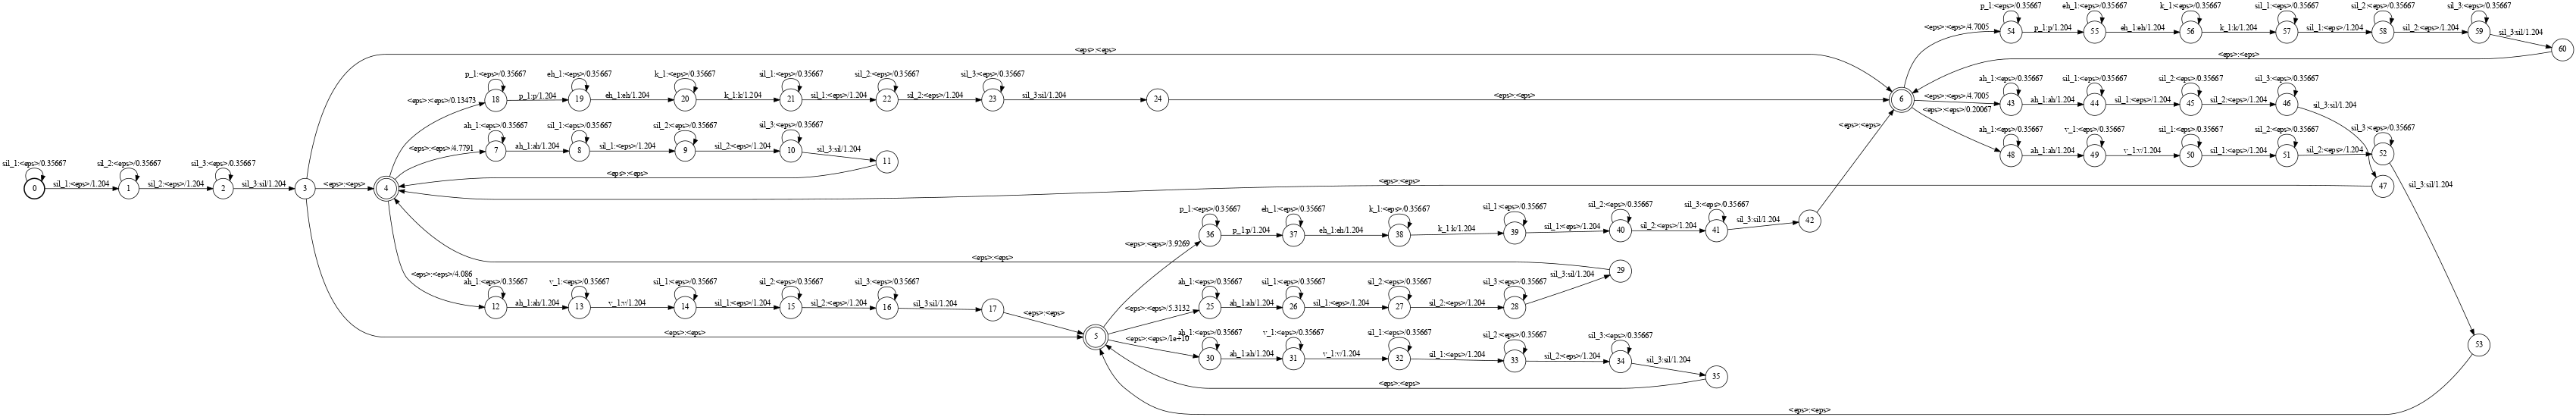

In [4]:
draw(f)

In [6]:
all_losses = []
decoding_time = []
backtrace_time = []
number_of_computations = []
i = 0
train_split = int(0.85 * len(glob.glob('/group/teaching/asr/labs/recordings/*.wav')))  # replace path if using your own audio files
print(train_split)

all_transcriptions = ''
for wav_file in tqdm(glob.glob('/group/teaching/asr/labs/recordings/*.wav')):    # replace path if using your own
                                                                           # audio files
    
    decoder  = MyViterbiDecoder(f, wav_file, verbose=False, use_pruning=False, determinized=True, bigram = True)
    decoder.decode()
    (state_path, words) = decoder.backtrace()  
    
    transcription = read_transcription(wav_file)
    all_transcriptions += transcription + ' '
    error_counts = wer.compute_alignment_errors(transcription, words)
    word_count = len(transcription.split())

    all_losses.append((error_counts, word_count))
    decoding_time.append(decoder.decode_time)
    backtrace_time.append(decoder.backtrace_time)
    number_of_computations.append(decoder.number_of_computiations)
    print(words)
    print(transcription)
    i += 1
    if i == 10:
        break

270


  0%|          | 1/318 [00:16<1:26:59, 16.46s/it]

Phones:  ['', ' ah v ', ' p ih k ah l d ', ' p ay p er ', ' dh iy ', ' ah v ', ' p iy t er ', '']
best_out_sequence:  sil ah v sil p ih k ah l d sil p ay p er sil dh iy sil ah v sil p iy t er sil
best_state_sequence:  [-1, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 7, 13, 13, 13, 13, 13, 13, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 45, 76, 188, 279, 389, 389, 389, 389, 389, 389, 389, 505, 505, 505, 505, 505, 505, 505, 505, 505, 621, 728, 728, 728, 728, 728, 728, 728, 728, 823, 823, 823, 823, 823, 823, 823, 907, 983, 663, 767, 767, 767, 861, 861, 861, 861, 861, 861, 861, 861, 861, 861, 861, 944, 1013, 1061, 1097, 463, 584, 584, 584, 584, 584, 584, 584, 584, 584, 584, 584, 691, 790, 882, 254, 357, 357, 357, 357, 357, 357, 35

  1%|          | 2/318 [00:27<1:09:54, 13.27s/it]

Phones:  ['', ' w eh r z ', ' p iy t er ', '']
best_out_sequence:  sil w eh r z sil p iy t er sil
best_state_sequence:  [-1, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 21, 39, 39, 39, 39, 39, 68, 114, 177, 177, 177, 177, 177, 177, 177, 177, 177, 261, 368, 487, 604, 604, 604, 604, 604, 604, 604, 604, 711, 711, 711, 711, 711, 711, 711, 711, 711, 711, 808, 808, 808, 808, 808, 808, 808, 808, 808, 808, 897, 974, 974, 974, 974, 974, 974, 974, 974, 974, 974, 974, 974, 974, 974, 974, 974, 974, 974, 974, 1034, 1034, 1034, 1034, 1034, 1034, 1034, 1034, 1034, 1034, 1034, 1034, 1034, 1034, 1034, 1034, 1034, 1034, 1034, 1034, 1034, 1034, 1034, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 1078, 

  1%|          | 3/318 [00:41<1:10:35, 13.45s/it]

Phones:  ['', ' p iy t er ', ' p ih k t ', ' p eh k ', '']
best_out_sequence:  sil p iy t er sil p ih k t sil p eh k sil
best_state_sequence:  [-1, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 16, 30, 30, 30, 30, 30, 30, 30, 30, 53, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 140, 210, 307, 430, 546, 546, 546, 546, 546, 546, 546, 546, 546, 546, 546, 546, 546, 546, 546, 546, 657, 657, 657, 657, 657, 761, 761, 761, 761, 761, 761, 761, 761, 761, 852, 852, 852, 852, 852, 852, 852, 852, 852, 852, 933, 933, 933, 1003, 445, 564, 564, 564, 564, 564, 564, 564, 564, 564, 564, 669, 669, 669, 669, 669, 669, 669, 773, 773, 773, 773, 773, 773, 773, 773, 773, 773, 773, 773, 773, 773, 867, 867, 867, 867, 867, 867, 949, 949, 949, 949, 949, 949, 949, 949, 949, 949, 949, 949, 949, 949, 949, 

  1%|▏         | 4/318 [00:55<1:11:28, 13.66s/it]

Phones:  ['', ' w eh r z ', ' dh iy ', ' p eh p er z ', '']
best_out_sequence:  sil w eh r z sil dh iy sil p eh p er z sil
best_state_sequence:  [-1, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 21, 39, 39, 39, 39, 39, 39, 68, 114, 177, 177, 177, 177, 177, 177, 177, 177, 177, 261, 368, 487, 605, 605, 605, 605, 605, 605, 605, 605, 714, 812, 901, 254, 358, 358, 358, 358, 358, 470, 470, 470, 470, 470, 470, 470, 470, 590, 590, 590, 590, 590, 590, 590, 590, 590, 590, 590, 590, 697, 795, 795, 795, 795, 795, 795, 795, 795, 795, 795, 795, 795, 795, 795, 795, 795, 885, 885, 885, 885, 885, 885, 885, 885, 885, 885, 965, 965, 965, 965, 9

  2%|▏         | 5/318 [01:10<1:14:38, 14.31s/it]

Phones:  ['', ' dh iy ', ' p ay p er ', ' p ih k ah l d ', ' p eh p er z ', '']
best_out_sequence:  sil dh iy sil p ay p er sil p ih k ah l d sil p eh p er z sil
best_state_sequence:  [-1, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 5, 9, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 38, 67, 113, 254, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 473, 473, 473, 473, 473, 473, 473, 473, 473, 473, 473, 594, 594, 594, 594, 594, 594, 594, 594, 594, 594, 594, 594, 594, 594, 702, 800, 890, 463, 583, 583, 583, 583, 583, 583, 583, 583, 583, 583, 583, 689, 689, 689, 689, 689, 689, 788, 788, 788, 788, 788, 788, 788, 788, 879, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 960, 1026, 1072, 1102, 663, 767, 767, 767, 767, 767, 767, 858, 940, 940, 940, 940, 940, 940, 940, 939

  2%|▏         | 6/318 [01:39<1:40:10, 19.26s/it]

Phones:  ['', ' dh iy ', ' p ih k ah l d ', ' p ay p er ', ' p ih k ah l d ', ' p eh k ', ' ah v ', ' p ih k ah l d ', ' ey ', ' ah v ', '']
best_out_sequence:  sil dh iy sil p ih k ah l d sil p ay p er sil p ih k ah l d sil p eh k sil ah v sil p ih k ah l d sil ey sil ah v sil
best_state_sequence:  [-1, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 9, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 38, 67, 112, 112, 

  2%|▏         | 7/318 [01:56<1:36:15, 18.57s/it]

Phones:  ['', ' dh iy ', ' p eh k ', ' p ih k ah l d ', ' p ih k ah l d ', ' p ih k t ', ' p ay p er ', ' p ih k t ', ' ey ', '']
best_out_sequence:  sil dh iy sil p eh k sil p ih k ah l d sil p ih k ah l d sil p ih k t sil p ay p er sil p ih k t sil ey sil
best_state_sequence:  [-1, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 9, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 38, 67, 113, 254, 358, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 470, 591, 591, 591, 591, 591, 591, 591, 591, 591, 698, 796, 305, 419, 533, 644, 748, 840, 840, 840, 840, 840, 840, 840, 924, 995, 1048, 663, 767, 860, 860, 860, 860, 860, 860, 860, 860, 860, 860, 860, 860, 943, 943, 943, 943, 943, 943, 943, 943, 1011, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 1059, 10

  3%|▎         | 8/318 [02:17<1:39:03, 19.17s/it]

Phones:  ['', ' p ih k t ', ' w eh r z ', ' ah v ', ' p eh k ', ' ah v ', ' p ih k ah l d ', ' p ih k t ', ' p eh p er z ', ' p ih k t ', ' p ay p er ', ' ey ', ' p eh k ', '']
best_out_sequence:  sil p ih k t sil w eh r z sil ah v sil p eh k sil ah v sil p ih k ah l d sil p ih k t sil p eh p er z sil p ih k t sil p ay p er sil ey sil p eh k sil
best_state_sequence:  [-1, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 8, 17, 32, 58, 98, 153, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 329, 444, 445, 566, 566, 566, 566, 566, 566, 566, 566, 566, 566, 566, 566, 566, 566, 566, 674, 674, 674, 778, 778, 778, 778, 778, 778, 778, 778, 778,

  3%|▎         | 9/318 [02:37<1:40:36, 19.53s/it]

Phones:  ['', ' dh iy ', ' p iy t er ', ' p ih k t ', ' p eh k ', ' ah v ', ' p ih k ah l d ', ' p eh p er z ', '']
best_out_sequence:  sil dh iy sil p iy t er sil p ih k t sil p eh k sil ah v sil p ih k ah l d sil p eh p er z sil
best_state_sequence:  [-1, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 9, 20, 20, 20, 20, 20, 20, 20, 20, 38, 67, 113, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 175, 254, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 471, 592, 592, 592, 592, 592, 592, 592, 699, 699, 699, 699, 797, 887, 430, 546, 546, 546, 546, 546, 546, 546, 546, 546, 546, 546, 546, 546, 546, 546, 546, 657, 657, 657, 657, 657, 657, 657, 657, 761, 761, 761, 761, 761, 761, 761, 761, 761, 7

  3%|▎         | 9/318 [02:55<1:40:38, 19.54s/it]

Phones:  ['', ' w eh r z ', ' dh iy ', ' p eh k ', ' p ih k ah l d ', ' w eh r z ', '']
best_out_sequence:  sil w eh r z sil dh iy sil p eh k sil p ih k ah l d sil w eh r z sil
best_state_sequence:  [-1, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 21, 39, 39, 39, 68, 114, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 261, 368, 487, 605, 605, 605, 605, 605, 714, 812, 901, 254, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 470, 470, 470, 470, 470, 470, 470, 470, 470, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 591, 698, 698, 698, 698, 698, 796, 796, 796, 796, 796, 796, 796, 796, 796, 796, 796, 796, 796, 305, 419, 533, 533, 533, 533, 533, 533, 533, 533, 533, 644, 644, 644, 644, 644, 644, 644, 644, 644, 644, 748, 840

In [7]:
# calculate the WER fo each file
import numpy as np
all_wer = []
for error_counts, word_count in all_losses:
    all_wer.append(sum(error_counts) / word_count)



print(f'The average WER is {np.mean(all_wer):.2%}')

The average WER is 33.11%


In [8]:
#Print dcoding time statistics
print(f'The average decoding time is {np.mean(decoding_time):.2f} seconds')
print(f'The average backtrace time is {np.mean(backtrace_time):.2f} seconds')
print(f'The average number of computations is {np.mean(number_of_computations):.2f}')



The average decoding time is 16.74 seconds
The average backtrace time is 0.00 seconds
The average number of computations is 692255.00
